In [3]:
!pip install --upgrade category_encoders
!pip install xgboost
!pip install hyperopt



     ---------------------------------------- 81.2/81.2 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 70.9/70.9 MB 2.1 MB/s eta 0:00:00
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [2]:
!pip show xgboost


Name: xgboost
Version: 1.7.5
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: c:\users\arkad\anaconda3\lib\site-packages
Requires: numpy, scipy
Required-by: 


In [3]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn import tree

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
import category_encoders as ce
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe
from hyperopt.pyll.base import scope
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [4]:
def symmetric_mean_absolute_percentage_error(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


Preprocessing

In [5]:
def remove_outliers(df, target_name):
    y=df[target_name]
    data_mean, data_std = mean(y), std(y)
# identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers

    df_ = df[df[target_name].between(lower, upper)]
    return df_

def scaler(df):
    ss=StandardScaler()
    df_=ss.fit_transform(df)
    return df_



In [6]:
def create_metrics_tag():
    return {'Specific': [], 'MAPE': [], 'SMAPE':[],  'MSLE': [], 'MSE':[], 'MAE':[], 'R2':[]}

def get_metrics(a, p, name):

    metrics = {'MAPE' : mean_absolute_percentage_error, 'SMAPE': symmetric_mean_absolute_percentage_error, 'MSLE': mean_squared_log_error, 'MSE': mean_squared_error, 'MAE': mean_absolute_error, 'R2':r2_score}
    tags=create_metrics_tag()

    for metric in metrics.keys():
        func=metrics[metric]
        val =func(a, p)
        tags[metric].append(val)

    tags['Specific'].append(name)
    df_ = pd.DataFrame(tags)
    return df_


In [7]:
def handleColumns(dropCols= []):
    CatColumns=['sex', 'smoker', 'region', 'weight', 'senility']
    ValColumns=['bmi',  'multiplier', 'children', 'age']
    catCols = [i for i in CatColumns if i not in dropCols]
    valCols = [i for i in ValColumns if i not in dropCols]
    return catCols, valCols

def getPipe(model, dropCols= []):

    catCols,valCols = handleColumns(dropCols)
    encoder = ce.JamesSteinEncoder(cols=catCols)
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), valCols+ catCols)
    ], remainder='passthrough') 

    modelpipe = Pipeline([
  ('encode_categorical', encoder),
  ('transformer', ct),
  ('classifier', model)
  ])

    return modelpipe

In [8]:
def preprocess(df,scal= False, dropN= None ):

    df_=df.copy()
    if(dropN):
        df_=df_.drop(dropN, axis=1)
    df_['weight']= pd.cut(df_['bmi'], bins=[0, 18.5, 25, 30, 40 , float('Inf')], labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Ultra_obese '])
    df_[df_['bmi']>35]
    df_['senility']= pd.cut(df_['age'], bins=[0, 30, 50, 60,float('Inf')], labels=['Young_adults', 'Adults', 'Old_adults', 'Pensioners'])
    df_['multiplier']= df_['age'] * df_['bmi']
    x=df_.copy().drop('charges', axis=1)
    y=df_['charges'].copy()
    if(scal):
        x = scaler(x)
    return x, y

Model evaluation


- Removed outliers
- No Missing Values
- Power Transform on target

### Feature Engineering:
- 'weight': categorical BMI
- 'senility': categorical Age
- 'multiplier': age * bmi

### Pipeline:
1. Categorical values: JamesSteinEncoder
2. Numerical values: StandardScaler
3. Model

In [9]:
df = pd.read_csv('archive\insurance.csv')
X,y=preprocess(df, scal=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)




Szukamy optymalnych parametrów poprzez kros - walidacje

In [10]:

def getModelDIc( model, dropCols = [] , powtransform= False):
    

  modelpipe = getPipe(model, dropCols)
  
  
  return {'model': modelpipe, 'powerTransform': powtransform, 'drop': dropCols}



In [18]:
X_train.region.unique()

array(['northwest', 'northeast', 'southeast', 'southwest'], dtype=object)

In [11]:

X_dummy = pd.get_dummies(X_train, drop_first= True)
X_dummy= pd.get_dummies(X_test, drop_first= True)


In [11]:
metrics = pd.DataFrame(create_metrics_tag())

models={}

name='Linear'
model= LinearRegression()
dropCols=[]
models[name]=getModelDIc( model ,dropCols)


name='Tree'
model= DecisionTreeRegressor(max_depth=4)
dropCols=['multiplier', 'region', 'weight', 'senility', 'sex']
models[name]=getModelDIc( model, dropCols)


name='RF RandomSearch'
model= RandomForestRegressor(n_estimators= 1577,
 min_samples_split= 2,
 min_samples_leaf= 4,
 max_features='sqrt',
 max_depth = 10,
 bootstrap= True )
dropCols=[]
models[name]=getModelDIc( model, dropCols, True)



name='RF HyperOpt'
model= RandomForestRegressor(n_estimators = 1089, max_depth=29, min_samples_leaf=12, random_state=1, max_features=7)
dropCols=[]
models[name]=getModelDIc( model, dropCols, False)


name='RF HyperOpt Tran'
model= RandomForestRegressor(n_estimators = 1089, max_depth=29, min_samples_leaf=12, random_state=1, max_features=7)
dropCols=[]
models[name]=getModelDIc( model, dropCols, True)



name='XGBRegressor HyperOpt'
model = XGBRegressor(seed=0, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=[]
models[name]=getModelDIc( model, dropCols, True)                    


for modelN in models:

    X_train_, X_test_, y_train_, y_test_= X_train, X_test, y_train, y_test
    model=models[modelN]['model']
    if(models[modelN]['powerTransform']):
        y_train_=np.log1p(y_train_)
    if(models[modelN]['drop']):
        X_train_=X_train_.drop(models[modelN]['drop'], axis=1)
        X_test_=X_test_.drop(models[modelN]['drop'], axis=1)
    model.fit(X_train_, y_train_)

    y_pred= model.predict(X_test_)
    y_pred=np.where(y_pred>0, y_pred,0 )
    if(models[modelN]['powerTransform']):
        y_pred=np.expm1(y_pred)
    
    metric=get_metrics(y_test_, y_pred, modelN)
    metrics = pd.concat([metrics, metric]).reset_index(drop=True)


In [12]:
color = (metrics.MAPE<0.17).map({True: 'background-color: green', False: ''})
display(metrics.style.apply(lambda s: color))

,Specific,MAPE,SMAPE,MSLE,MSE,MAE,R2
0,Linear,0.529010,44.638105,1.485989,34263203.272043,4317.969150,0.779301
1,Tree,0.331120,28.100890,0.178438,21093484.004597,2697.765431,0.864131
2,RF RandomSearch,0.189027,19.547119,0.128497,21324370.233214,2274.451626,0.862644
3,RF HyperOpt,0.306317,26.661792,0.166796,18345302.622367,2439.091618,0.881833
4,RF HyperOpt Tran,0.166282,17.653312,0.122768,18267912.438664,1939.920439,0.882331
5,XGBRegressor HyperOpt,0.157065,17.637683,0.130161,26304959.959414,2424.979979,0.830562


In [13]:
metricsDF= metrics.set_index('Specific')
metricNames=metricsDF.columns
modelNames=metricsDF.index

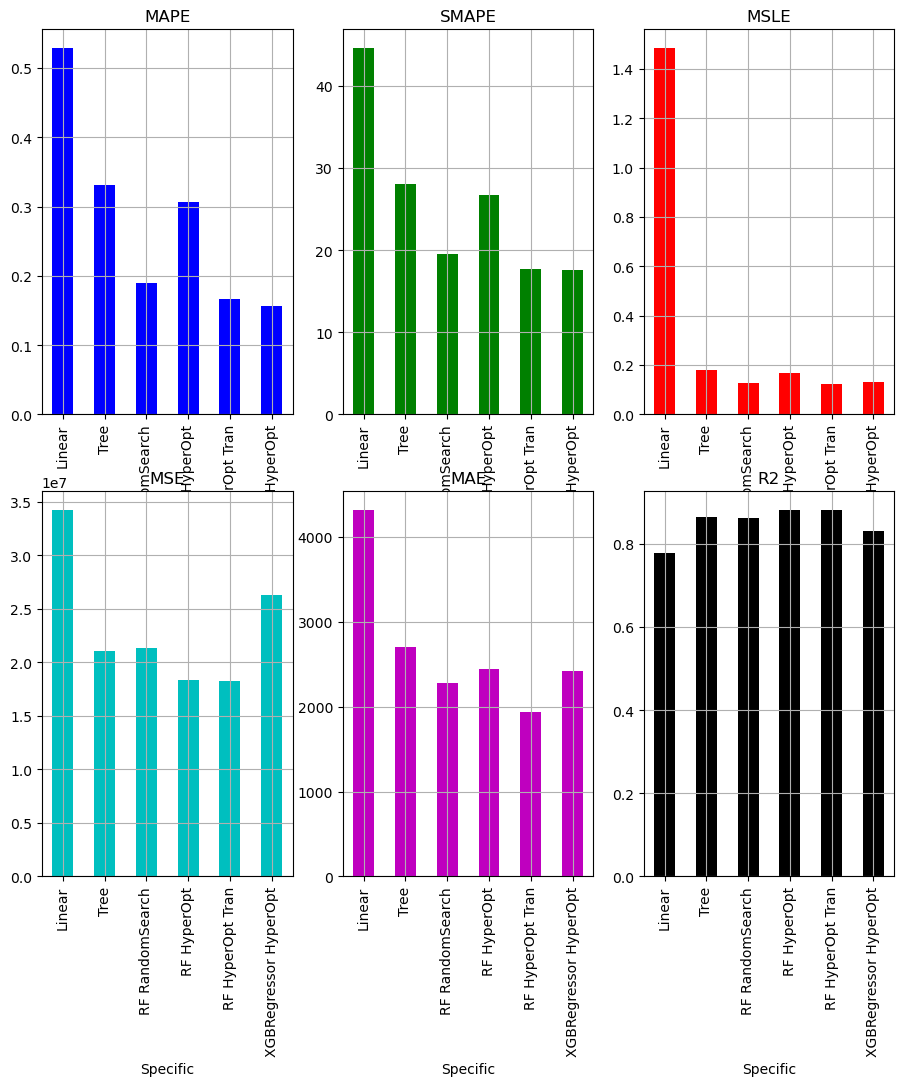

In [14]:
fig, axes = plt.subplots(figsize=(11,11),nrows=2, ncols=3)
ax1=plt.subplot(2,3,1)

colors=['b', 'g', 'r', 'c', 'm', 'k']

metricsDF["MAPE"].plot(ax=axes[0,0], kind='bar', grid=True, title= 'MAPE', color=colors[0] )
metricsDF["SMAPE"].plot(ax=axes[0,1], kind='bar', grid=True, title= 'SMAPE' , color=colors[1])
metricsDF["MSLE"].plot(ax=axes[0,2], kind='bar', grid=True, title= 'MSLE', color=colors[2])
metricsDF["MSE"].plot(ax=axes[1,0], kind='bar', grid=True, title ='MSE', color=colors[3])
metricsDF["MAE"].plot(ax=axes[1,1], kind='bar', grid=True, title ='MAE', color=colors[4])
metricsDF["R2"].plot(ax=axes[1,2], kind='bar', grid=True, title ='R2', color=colors[5])


ax1.grid(True)


#Optimalization

In [16]:
metrics2 = pd.DataFrame(create_metrics_tag())

models={}

name='RF with weight '
model= RandomForestRegressor(n_estimators = 1089, max_depth=29, min_samples_leaf=12, random_state=1, max_features=7)
dropCols=['multiplier', 'senility']
models[name]=getModelDIc( model, dropCols, True)

name='XGBR with added'
model = XGBRegressor(seed=0, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=[]
models[name]=getModelDIc( model, dropCols, True)   

name='XGBR without added'
model = XGBRegressor(seed=0, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=['multiplier', 'senility', 'weight']
models[name]=getModelDIc( model, dropCols, True)  

name='XGBR with multiplier'
model = XGBRegressor(seed=0, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=['weight']
models[name]=getModelDIc( model, dropCols, True)  


name='XGBR with senility'
model = XGBRegressor(seed=0, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=['multiplier','weight']
models[name]=getModelDIc( model, dropCols, True)  

name='XGBR with multiplier'
model = XGBRegressor(seed=0, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=['senility', 'weight']
models[name]=getModelDIc( model, dropCols, True)  



for modelN in models:

    X_train_, X_test_, y_train_, y_test_= X_train, X_test, y_train, y_test
    model=models[modelN]['model']
    if(models[modelN]['powerTransform']):
        y_train_=np.log1p(y_train_)
    if(models[modelN]['drop']):
        X_train_=X_train_.drop(models[modelN]['drop'], axis=1)
        X_test_=X_test_.drop(models[modelN]['drop'], axis=1)
    model.fit(X_train_, y_train_)

    y_pred= model.predict(X_test_)
    y_pred=np.where(y_pred>0, y_pred,0 )
    if(models[modelN]['powerTransform']):
        y_pred=np.expm1(y_pred)
    
    metric=get_metrics(y_test_, y_pred, modelN)
    metrics2 = pd.concat([metrics2, metric]).reset_index(drop=True)

In [17]:
color = (metrics2.MAPE<0.15).map({True: 'background-color: green', False: ''})
display(metrics2.style.apply(lambda s: color))

,Specific,MAPE,SMAPE,MSLE,MSE,MAE,R2
0,RF with weight,0.165470,17.690956,0.122800,18836798.405489,2034.167026,0.878667
1,XGBR with added,0.157065,17.637683,0.130161,26304959.959414,2424.979979,0.830562
2,XGBR without added,0.147317,16.879960,0.129286,26121518.765709,2378.140191,0.831744
3,XGBR with multiplier,0.157065,17.637683,0.130161,26304959.959414,2424.979979,0.830562
4,XGBR with senility,0.147317,16.879960,0.129286,26121518.765709,2378.140191,0.831744


In [18]:
metricsDF2= metrics2.set_index('Specific')
metricNames2=metricsDF2.columns
modelNames2=metricsDF2.index

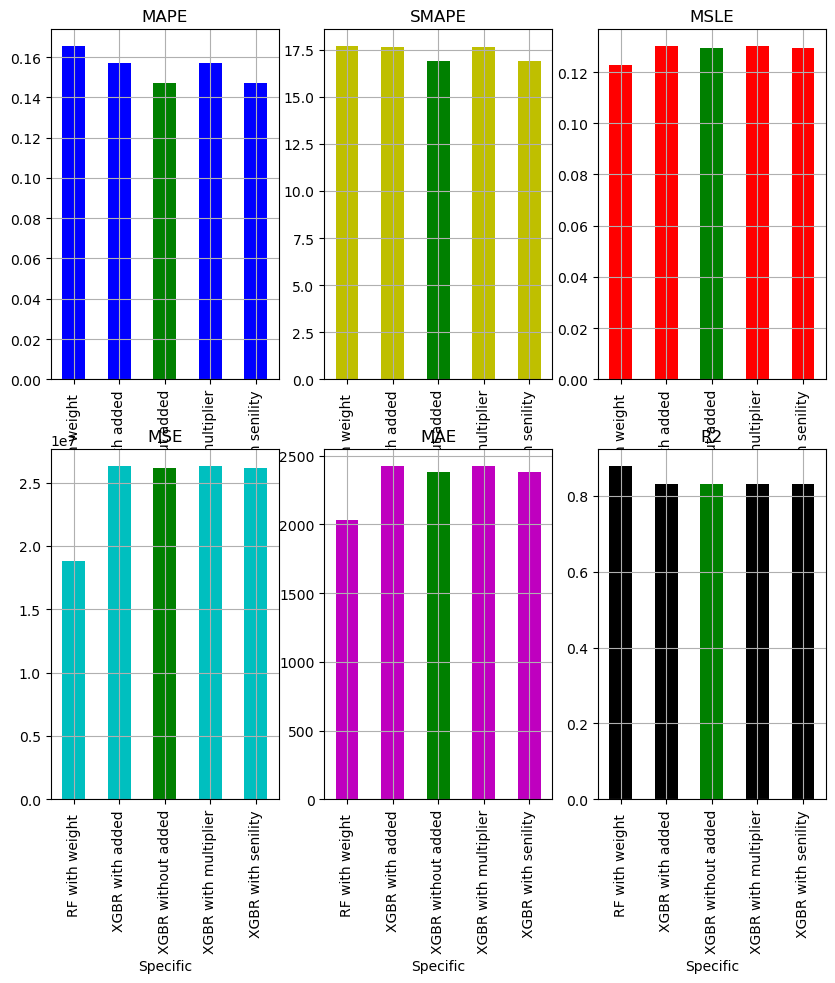

In [21]:
fig, axes = plt.subplots(figsize=(10,10),nrows=2, ncols=3)
ax1=plt.subplot(2,3,1)

colors=['b', 'y', 'r', 'c', 'm', 'k']

highlight = 'XGBR without added'
pos = metricsDF2.index.get_loc(highlight)

metricsDF2["MAPE"].plot(ax=axes[0,0], kind='bar', grid=True, title= 'MAPE', color=colors[0] )
metricsDF2["SMAPE"].plot(ax=axes[0,1], kind='bar', grid=True, title= 'SMAPE' , color=colors[1])
metricsDF2["MSLE"].plot(ax=axes[0,2], kind='bar', grid=True, title= 'MSLE', color=colors[2])
metricsDF2["MSE"].plot(ax=axes[1,0], kind='bar', grid=True, title ='MSE', color=colors[3])
metricsDF2["MAE"].plot(ax=axes[1,1], kind='bar', grid=True, title ='MAE', color=colors[4])
metricsDF2["R2"].plot(ax=axes[1,2], kind='bar', grid=True, title ='R2', color=colors[5])


axes[0,0].patches[pos].set_facecolor('g')
axes[0,1].patches[pos].set_facecolor('g')
axes[0,2].patches[pos].set_facecolor('g')
axes[1,0].patches[pos].set_facecolor('g')
axes[1,1].patches[pos].set_facecolor('g')
axes[1,2].patches[pos].set_facecolor('g')

ax1.grid(True)


#Feature Importances

,age,sex,bmi,children,smoker,region,senility
0,0.011137,0.03645,0.269871,0.019506,0.648172,0.014864,0.0


<Axes: >

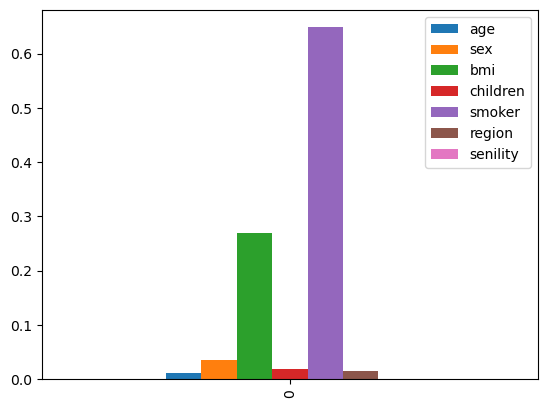

In [22]:
metrics2 = pd.DataFrame(create_metrics_tag())

models={}

name='XGBR with sensilty'
modelN = XGBRegressor(seed=66, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=['multiplier','weight' ]
models[name]=getModelDIc( modelN, dropCols, True)  

for modelN in models:

    X_train_, X_test_, y_train_, y_test_= X_train, X_test, y_train, y_test
    model=models[modelN]['model']
    if(models[modelN]['powerTransform']):
        y_train_=np.log1p(y_train_)
    if(models[modelN]['drop']):
        X_train_=X_train_.drop(models[modelN]['drop'], axis=1)
        X_test_=X_test_.drop(models[modelN]['drop'], axis=1)
    model.fit(X_train_, y_train_)
    y_pred= model.predict(X_test_)
    y_pred=np.where(y_pred>0, y_pred,0 )
    if(models[modelN]['powerTransform']):
        y_pred=np.expm1(y_pred)
    
    metric=get_metrics(y_test_, y_pred, modelN)
    metrics2 = pd.concat([metrics2, metric]).reset_index(drop=True)
    importances = model.named_steps["classifier"].feature_importances_


columns= X_train.columns
columns = [i for i in columns if i not in dropCols]

dfimportances=pd.DataFrame(data=importances.reshape(1,9- len(dropCols)), columns= columns)
display(dfimportances)


dfimportances.plot.bar()


In [24]:

models={}

name='XGBR'
modelN = XGBRegressor(seed=66, learning_rate=  0.02754445567920848, max_depth= 3, n_estimators= 164)
dropCols=['multiplier','weight' ,'senility']
models[name]=getModelDIc( modelN, dropCols, True)  

for modelN in models:

    X_train_, X_test_, y_train_, y_test_= X_train, X_test, y_train, y_test
    model=models[modelN]['model']
    if(models[modelN]['powerTransform']):
        y_train_=np.log1p(y_train_)
    if(models[modelN]['drop']):
        X_train_=X_train_.drop(models[modelN]['drop'], axis=1)
        X_test_=X_test_.drop(models[modelN]['drop'], axis=1)
    model.fit(X_train_, y_train_)
    y_pred= model.predict(X_test_)
    y_pred=np.where(y_pred>0, y_pred,0 )
    if(models[modelN]['powerTransform']):
        y_pred=np.expm1(y_pred)


## Creating predictions

In [25]:


columns= X_train.columns
columns = [i for i in columns if i not in dropCols]

Trials= pd.DataFrame(columns=columns )




In [26]:
lists=[]
lists.append( [24, 'male', 23, 1, 'yes', 'southeast'])
lists.append([35, 'female', 33, 2, 'no', 'northwest'])
lists.append( [59, 'female', 25, 1, 'no', 'southeast'])
lists.append([63, 'male', 30, 2, 'yes', 'northwest'])

for list in lists:
    Trials= pd.concat([Trials,pd.DataFrame([list], columns= columns)],ignore_index= True  )

y_pred= model.predict(Trials)
y_pred=np.where(y_pred>0, y_pred,0 )
y_pred=np.expm1(y_pred)

Trials['charges']= y_pred
Trials



,age,sex,bmi,children,smoker,region,charges
0,24,male,23,1,yes,southeast,17498.189453
1,35,female,33,2,no,northwest,6313.360352
2,59,female,25,1,no,southeast,13323.583008
3,63,male,30,2,yes,northwest,36334.214844


# END OF PRESENTATION



### RandomSearchGrid

In [28]:
with open(r'xgb_medical_cost_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:

space_rf = {"max_depth": hp.randint('max_depth', 1, 100),
             "n_estimators": scope.int(hp.qloguniform('n_estimators', 1, 10, 1)),
             "min_samples_leaf": hp.randint('min_samples_leaf', 1, 50),
             "max_features": hp.choice('max_features', ['sqrt', 2, 3, 4, 5, 6, 7, 8]),
             }
def minimize_rf(params):
    max_depth = params["max_depth"]
    max_features = params['max_features']
    min_samples = params['min_samples_leaf']
    n_estimators = int(params['n_estimators'])
    model = getPipe(RandomForestRegressor(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples, n_estimators=n_estimators))
    mean_cv_score = np.mean(cross_val_score(model, X_train, y_train))
    return -mean_cv_score


In [ ]:
best_rf = fmin(minimize_rf, space_rf, max_evals=20, algo=tpe.suggest)
best_rf

In [ ]:
#best_rf_regressor = RandomForestRegressor(n_estimators = 365, max_depth=47, min_samples_leaf=6, random_state=1)
{'max_depth': 47,
 'max_features': 5,
 'min_samples_leaf': 12,
 'n_estimators': 2639.0}

model = RandomForestRegressor(n_estimators = 2639, max_depth=47, min_samples_leaf=12, random_state=1, max_features=5)
best_rf_regressor = getPipe(model)
best_rf_regressor.fit(X_train, y_train)
y_pred_best = best_rf_regressor.predict(X_test)
r2_score(y_test, y_pred_best)

In [ ]:
importances = best_rf_regressor.named_steps["classifier"].feature_importances_


pd.DataFrame(data=importances.reshape(1,9), columns= X_train.columns)

#Hyperopt XGBoost

In [ ]:


space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 3, 18, 1),
    }

In [ ]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'max_depth': scope.int(hp.quniform("max_depth", 3, 18, 1)),
    'gamma': scope.int(hp.uniform ('gamma', 1,9)),
    'reg_alpha' : scope.int(hp.quniform('reg_alpha', 40,180,1)),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
     'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
    'n_estimators': scope.int(hp.quniform("n_estimators", 3, 18, 1))
}




In [ ]:
def objective(params):
    
    xgboost = XGBRegressor(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_trains, 
                            y=y_train, 
                            cv=3, 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 60, trials = Trials())


In [ ]:
print(space_eval(space, best))


In [ ]:
xgboost_bo = XGBRegressor(seed=0, 
                           learning_rate=space_eval(space, best)['learning_rate'], 
                           max_depth=space_eval(space, best)['max_depth'], 
                           n_estimators=space_eval(space, best)['n_estimators'],
                           ).fit(X_trains,y_train)
# Make prediction using the best model
bayesian_opt_predict = xgboost_bo.predict(X_tests)
# Get performance metrics
f1s = mean_squared_error(y_test, bayesian_opt_predict)
# Print result
print(f'The f1  value for the xgboost Bayesian optimization is {f1s:.4f}')

xgboost_bo.score(X_tests, y_test)